=== I-X Transient Simulation ===
Enter method (rk4/expm) (default: expm): rk4
Enter simulation time in hours (default: 70.0): 70
Enter time step in seconds (default: 3600.0): 3600
Enter base neutron flux (n/cm^2/s) (default: 4.42e+20): 4.42e20
Enter macroscopic fission cross-section (1/cm) (default: 0.008): 0.008
Enter lower flux percentage (default: 20.0): 20
Enter upper flux percentage (default: 100.0): 100
Enter flux step percentage (default: 20.0): 20
Enter number of runs for averaging runtime (default: 300): 300

Average runtime for RK4 method: 0.001563 seconds
Average runtime for Matrix Exponential method: 0.029215 seconds



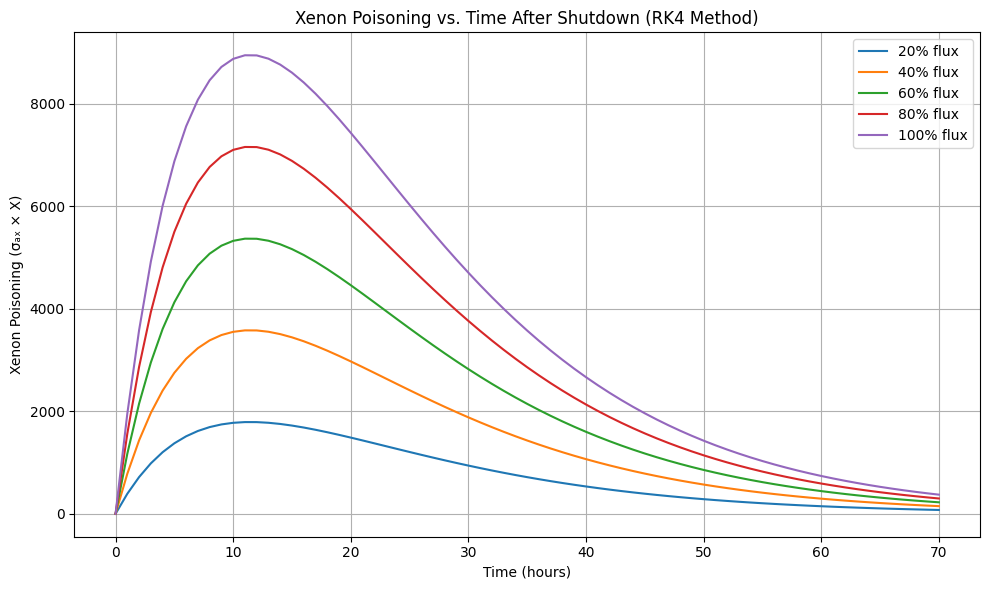

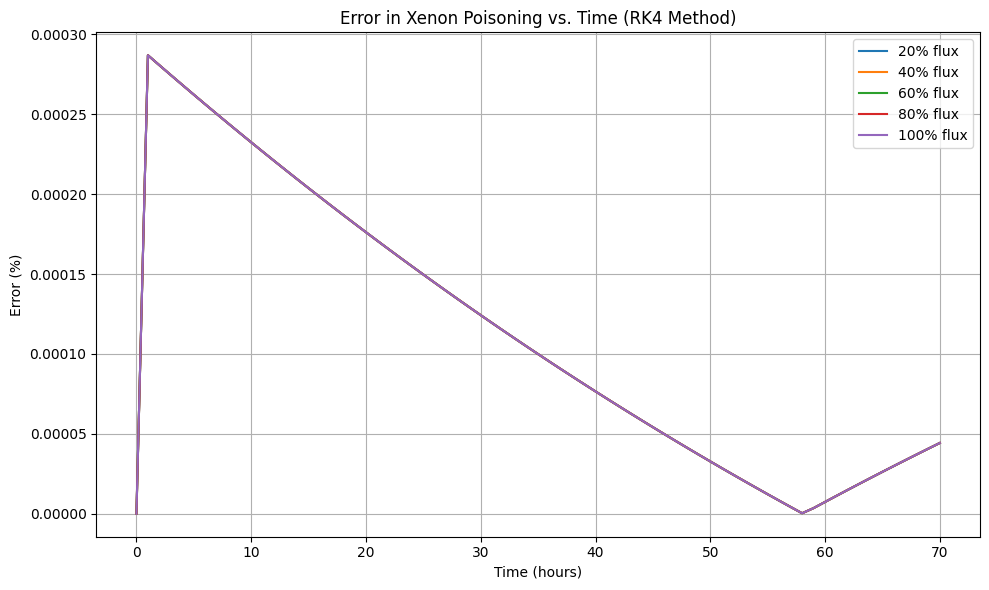

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time

# ---------------------------
# Fixed Nuclear Constants
# ---------------------------
lamI = 2.874e-5       # Decay constant for I-135 (1/s)
lamX = 2.027e-5       # Decay constant for Xe-135 (1/s)
Y_I = 0.061           # Fission yield for I-135
Y_X = 0.003           # Fission yield for Xe-135
sigma_aX = 2.75e-18   # Microscopic absorption cross-section of Xe-135 (cm^2)

# ---------------------------
# Helper Functions
# ---------------------------
def input_with_default(prompt, default):
    """Prompt the user with a default value."""
    s = input(f"{prompt} (default: {default}): ")
    if s.strip() == "":
        return default
    try:
        return type(default)(s)
    except:
        return default

def equilibrium_I_X(phi, Sig_f, Y_I, Y_X, lamI, lamX, sigma_aX):
    """
    Computes equilibrium concentrations before shutdown.

    """
    I0 = (Y_I * Sig_f * phi) / lamI
    X0 = (Y_X * Sig_f * phi + lamI * I0) / (lamX + sigma_aX * phi)
    return I0, X0

def X_analytical(t, I0, X0):
    """
    Returns the analytical solution for Xe-135 at time t (seconds) after shutdown.

    """
    return X0 * np.exp(-lamX*t) + (lamI * I0 / (lamX - lamI)) * (np.exp(-lamI*t) - np.exp(-lamX*t))

# ---------------------------
# RK4 Method Functions
# ---------------------------
def derivatives_rk(t, y):
    """Returns [dI/dt, dX/dt] for the I-X system after shutdown."""
    I, X = y
    dIdt = -lamI * I
    dXdt = lamI * I - lamX * X
    return np.array([dIdt, dXdt])

def rk4_step(func, t, y, dt):
    """Performs one RK4 step."""
    k1 = func(t, y)
    k2 = func(t + dt/2.0, y + dt/2.0 * k1)
    k3 = func(t + dt/2.0, y + dt/2.0 * k2)
    k4 = func(t + dt, y + dt * k3)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_shutdown_rk4(phi, Sig_f, t_end, dt):
    """
    Simulates the I-X transient after shutdown using the RK4 method.

    """
    I0, X0 = equilibrium_I_X(phi, Sig_f, Y_I, Y_X, lamI, lamX, sigma_aX)
    t = 0.0
    times = []
    I_vals = []
    X_vals = []
    y = np.array([I0, X0])

    while t <= t_end:
        times.append(t / 3600.0)
        I_vals.append(y[0])
        X_vals.append(y[1])
        y = rk4_step(derivatives_rk, t, y, dt)
        t += dt

    times = np.array(times)
    I_vals = np.array(I_vals)
    X_vals = np.array(X_vals)
    poisoning = sigma_aX * X_vals
    return times, I_vals, X_vals, poisoning, I0, X0

# ---------------------------
# Matrix Exponential Method Functions
# ---------------------------
def simulate_shutdown_expm(phi, Sig_f, t_end, dt):
    """
    Simulates the I-X transient after shutdown using the matrix exponential method.

    """
    I0, X0 = equilibrium_I_X(phi, Sig_f, Y_I, Y_X, lamI, lamX, sigma_aX)
    A = np.array([[-lamI,      0],
                  [ lamI, -lamX]])

    times_sec = np.arange(0, t_end + dt, dt)
    times = times_sec / 3600.0
    I_vals = []
    X_vals = []

    for t in times_sec:
        state = expm(A * t) @ np.array([I0, X0])
        I_vals.append(state[0])
        X_vals.append(state[1])

    I_vals = np.array(I_vals)
    X_vals = np.array(X_vals)
    poisoning = sigma_aX * X_vals  # Equation #26
    return times, I_vals, X_vals, poisoning, I0, X0

# ---------------------------
# General Simulation Routine
# ---------------------------
def simulate_shutdown(method, phi, Sig_f, t_end, dt):
    """
    General simulation routine to simulate the I-X transient after shutdown.
    method: "rk4" or "expm"
    """
    if method.lower() == "rk4":
        return simulate_shutdown_rk4(phi, Sig_f, t_end, dt)
    elif method.lower() == "expm":
        return simulate_shutdown_expm(phi, Sig_f, t_end, dt)
    else:
        raise ValueError("Unknown method. Please choose 'rk4' or 'expm'.")

# ---------------------------
# Main Routine
# ---------------------------
def main():
    print("=== I-X Transient Simulation ===")
    method = input("Enter method (rk4/expm) (default: expm): ").strip() or "expm"

    sim_time_hours = input_with_default("Enter simulation time in hours", 70.0)
    dt = input_with_default("Enter time step in seconds", 3600.0)
    phi_base_user = input_with_default("Enter base neutron flux (n/cm^2/s)", 4.42e20)
    Sig_f_user = input_with_default("Enter macroscopic fission cross-section (1/cm)", 0.008)
    lower_flux_percent = input_with_default("Enter lower flux percentage", 20.0)
    upper_flux_percent = input_with_default("Enter upper flux percentage", 100.0)
    flux_step = input_with_default("Enter flux step percentage", 20.0)
    num_runs = input_with_default("Enter number of runs for averaging runtime", 300)

    # Create flux range based on percentage inputs.
    flux_percentages = np.arange(lower_flux_percent, upper_flux_percent + flux_step, flux_step)
    flux_levels = flux_percentages / 100.0 * phi_base_user
    t_end = sim_time_hours * 3600.0  # convert hours to seconds

    # ---------------------------
    # Calculate Average Runtimes for Both Methods
    # ---------------------------
    total_time_rk4 = 0.0
    total_time_expm = 0.0
    # Choose a representative flux (say, 100% of the base flux)
    phi_chosen = phi_base_user

    for i in range(num_runs):
        start = time.perf_counter()
        simulate_shutdown("rk4", phi_chosen, Sig_f_user, t_end, dt)
        total_time_rk4 += time.perf_counter() - start

    for i in range(num_runs):
        start = time.perf_counter()
        simulate_shutdown("expm", phi_chosen, Sig_f_user, t_end, dt)
        total_time_expm += time.perf_counter() - start

    avg_time_rk4 = total_time_rk4 / num_runs
    avg_time_expm = total_time_expm / num_runs

    print(f"\nAverage runtime for RK4 method: {avg_time_rk4:.6f} seconds")
    print(f"Average runtime for Matrix Exponential method: {avg_time_expm:.6f} seconds\n")

    # ---------------------------
    # Plot Xenon Poisoning vs. Time for Different Flux Levels
    # ---------------------------
    plt.figure(figsize=(10, 6))
    for i, phi in enumerate(flux_levels):
        times, I_vals, X_vals, poisoning, I0, X0 = simulate_shutdown(method, phi, Sig_f_user, t_end, dt)
        plt.plot(times, poisoning,  label=f'{flux_percentages[i]:.0f}% flux')
    plt.xlabel('Time (hours)')
    plt.ylabel('Xenon Poisoning (σₐₓ × X)')
    plt.title(f'Xenon Poisoning vs. Time After Shutdown ({method.upper()} Method)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---------------------------
    # Plot Error Percentage vs. Time for Different Flux Levels
    # ---------------------------
    plt.figure(figsize=(10, 6))
    for i, phi in enumerate(flux_levels):
        times, I_vals, X_vals, poisoning, I0, X0 = simulate_shutdown(method, phi, Sig_f_user, t_end, dt)
        error_pct = []
        for j, t_hr in enumerate(times):
            t_sec = t_hr * 3600.0
            X_ana = X_analytical(t_sec, I0, X0)
            poisoning_ana = sigma_aX * X_ana
            if abs(poisoning_ana) > 1e-15:
                err = 100.0 * abs(poisoning[j] - poisoning_ana) / abs(poisoning_ana)
            else:
                err = 0.0
            error_pct.append(err)
        plt.plot(times, error_pct, label=f'{flux_percentages[i]:.0f}% flux')
    plt.xlabel('Time (hours)')
    plt.ylabel('Error (%)')
    plt.title(f'Error in Xenon Poisoning vs. Time ({method.upper()} Method)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    main()
